***
*Project:* Helmholtz Machine on Niche Construction

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Experiment 4</span> 

# Helmholtz Machine Test on Random Set

Instead of the toy model on well-formed set, we and more randomness to the dataset with Baysian mixture of Gaussians.

*Created:* December 24, 2023

*Updated:* December 24, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

In [2]:
structure = [[10,8,7,6,5,3,1]]
n_dz = np.array(structure)
n_dz

array([[10,  8,  7,  6,  5,  3,  1]])

In [105]:
Phi, Theta = ut.parameter_initialization("zero",n_dz)  # "zero" or "random"

In [106]:
value_set = [1,0]
activation_type = "tanh"
bias = [False,False,True] # [instantiation bias, MLP bias,data bias]

In [107]:
n = n_dz[0,0]
k = 2
n_data = 500
random_set = ut.random_generate(k,n,n_data,value_set)
random_set

array([[1, 0, 1, ..., 0, 1, 0],
       [0, 1, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [108]:
values,counts = np.unique(random_set, axis=1, return_counts = True)
counts.size

387

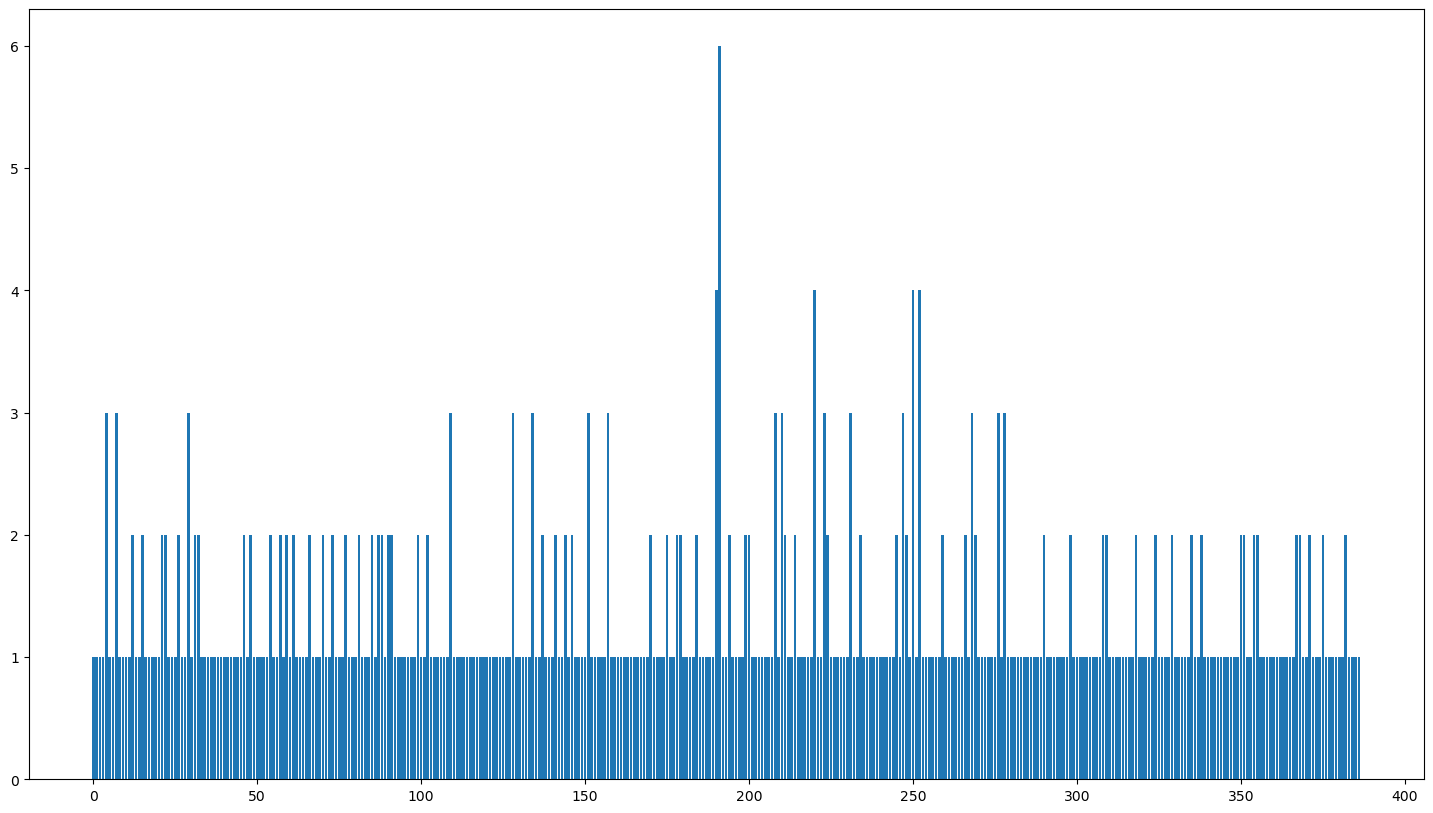

In [109]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(np.arange(counts.size),counts)
# ax.set(xlim=(0, x_lim), xticks=xtick)
plt.show()

In [8]:
well_formed_set = ut.well_formed_generate(n,value_set)
well_formed_set

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [151]:
dataset = random_set
entire_set = ut.all_comb(n, value_set)

In [152]:
reordered_set = ut.reorder_all_comb(entire_set,dataset)
reordered_set

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [153]:
def metrics(generation,reordered_set,dataset):
    """
    Arguments:
    generation -- generated instances after training, numpy array of shape (n,n_sample), n is the length of input layer, 
    n_sample is the number of datapoints generated
    reordered_set -- entire_set reordered as columns 0-k represents valid instances contained in the dataset, 
    columns k-2^n represents false instances not in the dataset. numpy array of shape (n,2^n)
    dataset -- numpy array of shape (n,n_data), n_data is the number of datapoints.
    
    Returns:
    distribution -- assigned category for generated samples based on reordered set, numpy array of shape (n_sample, )
    data_dist -- assigned category for dataset  based on reordered set, numpy array of shape (n_data, )
    statistics -- python dictionary with keys:
        percent -- percentage of positive instances
        n_fn -- number of false negative samples, missing evidence
        FN -- position of false negative samples, numpy array of shape (k-n_fn, )
        n_fp -- number of false positive samples, outliers
        FP -- position and counts of false positive samples, numpy array of shape (2,n_fp)
    MSE -- mean squared error between the generation Q and the data evidence P on the support of P (on positive instances only).
    """
    n_sample = generation.shape[1]
    n_data = dataset.shape[1]
    distribution = np.zeros((n_sample, ),dtype = int)
    for i in range(n_sample):
        for j in range(reordered_set.shape[1]):
            if np.array_equal(generation[:,i], reordered_set[:,j]):
                distribution[i] = j
                break
    values_t, counts_t = np.unique(distribution, return_counts=True)
    
    data_dist = np.zeros((n_data, ),dtype = int)
    for i in range(n_data):
        for j in range(reordered_set.shape[1]):
            if np.array_equal(dataset[:,i], reordered_set[:,j]):
                data_dist[i] = j
                break
    values_d, counts_d  = np.unique(data_dist, return_counts=True)
    k = counts_d.size
    
    
    # statistics
    percent = np.sum(counts_t[values_t < k])/n_sample
    n_fn = k-values_t[values_t < k].size
    FN = np.zeros((n_fn,),dtype = int)
    dist_positive = np.array([values_t[values_t < k], counts_t[values_t < k]])
    s = 0
    values_t[values_t < k]
    dist_values = np.append(np.append(-1,values_t[values_t < k]),k)   # append 0 and k in the range
    
    for i in range(dist_values.size-1):
        diff = dist_values[i+1] - dist_values[i]
        for j in range(1,diff):
            FN[s] = dist_values[i]+j
            dist_positive = np.append(dist_positive, np.array([[dist_values[i]+j],[0]]),axis = 1)
            s += 1
    dist_positive = np.unique(dist_positive,axis = 1)
    n_fp = values_t[values_t >= k].size
    FP = np.array([values_t[values_t >= k], counts_t[values_t >= k]])
    statistics = {'percent': percent, 'FN': FN, 'n_fn':n_fn, 'FP': FP, 'n_fp':n_fp}
    
    # metric 2: distribution difference. Since our ditributions are discrete, we calculate a mean squared error (MSE) between 
    #           the generation Q and the data evidence P on the support of P (on positive instances only).
    
    counts_t = counts_t/n_sample*n_data  # distribution in the same scale as dataset
    MSE = np.sum((dist_positive[1,:]/n_sample*n_data - counts_d)**2)/k
    ABS_Error = np.abs(dist_positive[1,:]/n_sample*n_data - counts_d).sum()/k
    
    return distribution,data_dist,statistics, MSE,ABS_Error

Train the model:

In [154]:
lr = 0.01
epoch = 1000
n_data = dataset.shape[1]
n_layer = n_dz.shape[1]

In [155]:
### Training without constraints, accuracy 0.55, not ideal

for e in range (epoch):
    index = np.random.permutation(n_data)
    Loss_Q_total = np.zeros(n_layer)
    Loss_P_total = np.zeros(n_layer)
    for i in range(n_data):
        d0 = dataset[:,index[i]:index[i]+1]
        Alpha_Q = ut.wake_sample(n_dz,d0,value_set,Phi,activation_type,bias)
        Theta,Loss_P = ut.sleep_update_delta(Theta,Alpha_Q,lr,n_dz,value_set,activation_type,bias)
        Alpha_P = ut.sleep_sample(n_dz,value_set,Theta,activation_type,bias)
        Phi,Loss_Q = ut.wake_update_delta(Phi,Alpha_P,lr,n_dz,value_set,activation_type,bias)
        
        Loss_Q_total += Loss_Q
        Loss_P_total += Loss_P
    Loss_Q_total = Loss_Q_total/n_data
    Loss_P_total = Loss_P_total/n_data
    print('Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))

Loss_Q: [2.09 1.59 1.6  1.33 0.61 0.   7.22] Loss_P: [ 3.52  2.8   1.88  1.79  1.32  0.66 11.99]
Loss_Q: [1.83 1.65 1.61 1.31 0.55 0.   6.95] Loss_P: [ 3.43  2.63  1.8   1.73  1.34  0.62 11.55]
Loss_Q: [1.79 1.63 1.65 1.31 0.55 0.   6.94] Loss_P: [ 3.38  2.68  1.74  1.78  1.39  0.67 11.64]
Loss_Q: [1.86 1.62 1.57 1.29 0.57 0.   6.91] Loss_P: [ 3.4   2.67  1.64  1.71  1.34  0.66 11.43]
Loss_Q: [1.85 1.6  1.57 1.27 0.59 0.   6.87] Loss_P: [ 3.35  2.75  1.69  1.73  1.33  0.64 11.48]
Loss_Q: [1.83 1.57 1.57 1.27 0.56 0.   6.8 ] Loss_P: [ 3.42  2.77  1.65  1.74  1.28  0.63 11.5 ]
Loss_Q: [1.9  1.55 1.64 1.26 0.57 0.   6.93] Loss_P: [ 3.38  2.79  1.71  1.79  1.31  0.66 11.63]
Loss_Q: [1.85 1.64 1.7  1.37 0.62 0.   7.17] Loss_P: [ 3.38  2.78  1.68  1.83  1.31  0.64 11.63]
Loss_Q: [1.81 1.67 1.66 1.33 0.57 0.   7.05] Loss_P: [ 3.37  2.75  1.69  1.82  1.34  0.69 11.66]
Loss_Q: [1.89 1.62 1.69 1.32 0.54 0.   7.06] Loss_P: [ 3.38  2.79  1.67  1.84  1.32  0.64 11.64]
Loss_Q: [1.9  1.65 1.67 1.33 0

Loss_Q: [1.9  1.82 1.65 1.29 0.66 0.   7.32] Loss_P: [ 3.39  2.69  1.97  1.74  1.28  0.73 11.8 ]
Loss_Q: [1.92 1.86 1.71 1.29 0.67 0.   7.44] Loss_P: [ 3.38  2.71  1.91  1.82  1.3   0.72 11.84]
Loss_Q: [1.81 1.82 1.63 1.2  0.65 0.   7.11] Loss_P: [ 3.45  2.71  1.94  1.81  1.24  0.73 11.88]
Loss_Q: [1.89 1.79 1.71 1.24 0.68 0.   7.31] Loss_P: [ 3.45  2.71  1.93  1.8   1.23  0.69 11.81]
Loss_Q: [1.84 1.91 1.69 1.22 0.66 0.   7.32] Loss_P: [ 3.51  2.64  1.93  1.76  1.25  0.72 11.81]
Loss_Q: [1.87 1.84 1.73 1.25 0.65 0.   7.35] Loss_P: [ 3.39  2.69  1.95  1.83  1.27  0.72 11.86]
Loss_Q: [1.9  1.83 1.68 1.29 0.66 0.   7.37] Loss_P: [ 3.41  2.7   1.96  1.82  1.28  0.73 11.9 ]
Loss_Q: [1.86 1.86 1.7  1.27 0.65 0.   7.35] Loss_P: [ 3.37  2.72  1.97  1.85  1.26  0.71 11.89]
Loss_Q: [1.91 1.82 1.71 1.28 0.65 0.   7.37] Loss_P: [ 3.42  2.7   1.89  1.83  1.28  0.72 11.83]
Loss_Q: [1.85 1.89 1.75 1.26 0.66 0.   7.41] Loss_P: [ 3.37  2.66  1.97  1.93  1.27  0.74 11.93]
Loss_Q: [1.86 1.91 1.76 1.27 0

Loss_Q: [1.81 1.71 1.93 1.16 0.6  0.   7.22] Loss_P: [ 3.38  2.77  1.79  2.14  1.22  0.64 11.94]
Loss_Q: [1.85 1.72 1.99 1.2  0.59 0.   7.36] Loss_P: [ 3.33  2.79  1.75  2.09  1.19  0.64 11.8 ]
Loss_Q: [1.9  1.74 1.99 1.12 0.59 0.   7.34] Loss_P: [ 3.39  2.79  1.84  2.15  1.2   0.64 12.01]
Loss_Q: [1.91 1.68 1.98 1.24 0.61 0.   7.42] Loss_P: [ 3.37  2.78  1.77  2.14  1.25  0.66 11.96]
Loss_Q: [1.87 1.74 2.   1.13 0.56 0.   7.3 ] Loss_P: [ 3.43  2.76  1.71  2.08  1.18  0.63 11.78]
Loss_Q: [1.88 1.68 1.98 1.1  0.58 0.   7.23] Loss_P: [ 3.35  2.84  1.78  2.16  1.16  0.67 11.96]
Loss_Q: [1.8  1.68 1.97 1.13 0.59 0.   7.17] Loss_P: [ 3.38  2.75  1.74  2.08  1.14  0.64 11.73]
Loss_Q: [1.9  1.63 1.98 1.2  0.63 0.   7.33] Loss_P: [ 3.35  2.74  1.76  2.1   1.18  0.65 11.77]
Loss_Q: [1.86 1.63 1.95 1.07 0.6  0.   7.12] Loss_P: [ 3.31  2.82  1.71  2.07  1.12  0.64 11.66]
Loss_Q: [1.88 1.62 1.96 1.1  0.64 0.   7.19] Loss_P: [ 3.34  2.8   1.72  2.08  1.04  0.65 11.64]
Loss_Q: [1.84 1.6  1.92 1.   0

Loss_Q: [1.82 1.56 1.94 0.99 0.63 0.   6.93] Loss_P: [ 3.37  2.71  1.74  1.99  0.97  0.69 11.47]
Loss_Q: [1.88 1.59 1.87 0.93 0.63 0.   6.9 ] Loss_P: [ 3.45  2.74  1.7   1.97  0.93  0.73 11.53]
Loss_Q: [1.9  1.61 1.79 0.96 0.65 0.   6.91] Loss_P: [ 3.38  2.75  1.69  1.91  1.    0.72 11.46]
Loss_Q: [1.85 1.52 1.74 0.94 0.62 0.   6.68] Loss_P: [ 3.39  2.73  1.66  1.92  0.97  0.72 11.39]
Loss_Q: [1.85 1.6  1.83 0.98 0.64 0.   6.9 ] Loss_P: [ 3.45  2.69  1.79  1.97  0.95  0.7  11.55]
Loss_Q: [1.81 1.6  1.86 1.   0.64 0.   6.91] Loss_P: [ 3.37  2.71  1.65  1.93  0.95  0.71 11.32]
Loss_Q: [1.8  1.55 1.86 0.99 0.63 0.   6.84] Loss_P: [ 3.46  2.71  1.66  1.99  0.98  0.69 11.5 ]
Loss_Q: [1.81 1.57 1.84 0.98 0.62 0.   6.83] Loss_P: [ 3.38  2.71  1.67  1.97  0.91  0.66 11.31]
Loss_Q: [1.84 1.58 1.88 0.93 0.6  0.   6.84] Loss_P: [ 3.4   2.68  1.66  1.97  1.02  0.69 11.42]
Loss_Q: [1.83 1.53 1.89 0.97 0.61 0.   6.83] Loss_P: [ 3.39  2.67  1.65  1.99  0.99  0.68 11.37]
Loss_Q: [1.86 1.56 1.9  1.05 0

Loss_Q: [1.76 1.77 1.59 1.11 0.6  0.   6.83] Loss_P: [ 3.49  2.53  1.91  1.67  1.12  0.63 11.35]
Loss_Q: [1.82 1.69 1.56 1.06 0.53 0.   6.67] Loss_P: [ 3.44  2.62  1.85  1.64  1.12  0.62 11.29]
Loss_Q: [1.78 1.65 1.57 1.14 0.5  0.   6.65] Loss_P: [ 3.47  2.62  1.81  1.66  1.2   0.58 11.34]
Loss_Q: [1.82 1.67 1.53 1.13 0.5  0.   6.65] Loss_P: [ 3.41  2.64  1.8   1.68  1.17  0.58 11.28]
Loss_Q: [1.82 1.59 1.57 1.14 0.5  0.   6.63] Loss_P: [ 3.42  2.67  1.77  1.69  1.17  0.6  11.32]
Loss_Q: [1.79 1.66 1.68 1.13 0.54 0.   6.8 ] Loss_P: [ 3.39  2.62  1.8   1.73  1.17  0.61 11.32]
Loss_Q: [1.81 1.59 1.63 1.1  0.55 0.   6.67] Loss_P: [ 3.49  2.6   1.69  1.7   1.19  0.6  11.27]
Loss_Q: [1.8  1.54 1.64 1.1  0.54 0.   6.61] Loss_P: [ 3.4   2.62  1.67  1.7   1.16  0.57 11.12]
Loss_Q: [1.75 1.6  1.68 1.12 0.57 0.   6.73] Loss_P: [ 3.47  2.66  1.69  1.74  1.17  0.66 11.4 ]
Loss_Q: [1.76 1.55 1.69 1.16 0.59 0.   6.75] Loss_P: [ 3.46  2.57  1.68  1.76  1.2   0.62 11.3 ]
Loss_Q: [1.8  1.57 1.63 1.14 0

Loss_Q: [1.74 1.68 1.7  1.27 0.62 0.   7.01] Loss_P: [ 3.5   2.52  1.77  1.81  1.28  0.73 11.62]
Loss_Q: [1.78 1.61 1.76 1.27 0.62 0.   7.05] Loss_P: [ 3.44  2.54  1.74  1.86  1.34  0.76 11.68]
Loss_Q: [1.77 1.64 1.76 1.29 0.65 0.   7.1 ] Loss_P: [ 3.43  2.53  1.81  1.86  1.34  0.78 11.75]
Loss_Q: [1.71 1.68 1.71 1.27 0.65 0.   7.02] Loss_P: [ 3.45  2.53  1.79  1.79  1.28  0.78 11.62]
Loss_Q: [1.79 1.61 1.67 1.29 0.65 0.   7.01] Loss_P: [ 3.41  2.55  1.79  1.79  1.31  0.75 11.6 ]
Loss_Q: [1.73 1.64 1.76 1.22 0.66 0.   7.01] Loss_P: [ 3.42  2.6   1.74  1.79  1.27  0.78 11.59]
Loss_Q: [1.76 1.6  1.74 1.22 0.62 0.   6.94] Loss_P: [ 3.41  2.56  1.7   1.84  1.29  0.73 11.54]
Loss_Q: [1.81 1.65 1.82 1.22 0.63 0.   7.13] Loss_P: [ 3.4   2.6   1.79  1.86  1.26  0.75 11.67]
Loss_Q: [1.85 1.72 1.8  1.23 0.64 0.   7.24] Loss_P: [ 3.41  2.6   1.77  1.84  1.22  0.74 11.59]
Loss_Q: [1.79 1.63 1.79 1.21 0.65 0.   7.06] Loss_P: [ 3.4   2.63  1.77  1.86  1.19  0.77 11.61]
Loss_Q: [1.85 1.63 1.73 1.18 0

Loss_Q: [1.8  1.71 1.74 1.08 0.64 0.   6.96] Loss_P: [ 3.41  2.54  1.89  1.8   1.09  0.75 11.48]
Loss_Q: [1.78 1.72 1.69 1.08 0.64 0.   6.92] Loss_P: [ 3.4   2.56  1.92  1.73  1.11  0.71 11.43]
Loss_Q: [1.8  1.71 1.74 1.12 0.63 0.   7.01] Loss_P: [ 3.38  2.63  1.88  1.75  1.12  0.72 11.49]
Loss_Q: [1.78 1.71 1.73 1.03 0.67 0.   6.92] Loss_P: [ 3.38  2.66  1.88  1.79  1.09  0.81 11.61]
Loss_Q: [1.87 1.68 1.78 1.05 0.7  0.   7.09] Loss_P: [ 3.37  2.65  1.86  1.81  1.11  0.77 11.58]
Loss_Q: [1.81 1.74 1.77 1.09 0.65 0.   7.06] Loss_P: [ 3.4   2.66  1.9   1.84  1.12  0.79 11.72]
Loss_Q: [1.79 1.78 1.77 1.09 0.63 0.   7.06] Loss_P: [ 3.38  2.63  1.98  1.81  1.11  0.75 11.67]
Loss_Q: [1.78 1.77 1.74 1.   0.66 0.   6.95] Loss_P: [ 3.4   2.55  1.94  1.87  1.14  0.78 11.68]
Loss_Q: [1.86 1.75 1.77 1.09 0.67 0.   7.13] Loss_P: [ 3.4   2.56  1.98  1.83  1.08  0.79 11.63]
Loss_Q: [1.84 1.73 1.81 1.02 0.68 0.   7.07] Loss_P: [ 3.45  2.53  1.96  1.84  1.06  0.76 11.61]
Loss_Q: [1.75 1.8  1.79 1.12 0

Loss_Q: [1.7  1.77 1.77 1.   0.76 0.   7.01] Loss_P: [ 3.44  2.51  1.97  1.86  1.04  0.85 11.67]
Loss_Q: [1.72 1.74 1.79 0.99 0.77 0.   7.01] Loss_P: [ 3.46  2.47  1.97  1.91  1.05  0.84 11.7 ]
Loss_Q: [1.72 1.74 1.85 1.03 0.77 0.   7.11] Loss_P: [ 3.46  2.45  1.94  1.89  1.    0.84 11.59]
Loss_Q: [1.68 1.72 1.84 1.01 0.78 0.   7.03] Loss_P: [ 3.46  2.44  1.96  1.89  1.07  0.87 11.69]
Loss_Q: [1.68 1.67 1.77 0.99 0.77 0.   6.89] Loss_P: [ 3.42  2.42  1.85  1.87  1.05  0.85 11.46]
Loss_Q: [1.66 1.67 1.8  1.02 0.75 0.   6.89] Loss_P: [ 3.46  2.49  1.84  1.88  1.    0.84 11.51]
Loss_Q: [1.69 1.65 1.81 1.05 0.72 0.   6.92] Loss_P: [ 3.46  2.54  1.79  1.91  1.02  0.85 11.57]
Loss_Q: [1.66 1.66 1.75 1.03 0.72 0.   6.82] Loss_P: [ 3.44  2.41  1.82  1.84  1.05  0.8  11.37]
Loss_Q: [1.67 1.69 1.77 1.1  0.78 0.   7.  ] Loss_P: [ 3.41  2.48  1.91  1.82  1.04  0.88 11.54]
Loss_Q: [1.62 1.7  1.69 1.03 0.75 0.   6.79] Loss_P: [ 3.47  2.43  1.89  1.83  1.07  0.85 11.54]
Loss_Q: [1.71 1.72 1.72 1.07 0

Loss_Q: [1.82 1.78 1.73 1.03 0.72 0.   7.09] Loss_P: [ 3.41  2.52  2.    1.85  1.06  0.82 11.66]
Loss_Q: [1.79 1.84 1.67 1.02 0.7  0.   7.02] Loss_P: [ 3.42  2.58  2.03  1.83  1.06  0.75 11.66]
Loss_Q: [1.79 1.83 1.7  1.01 0.72 0.   7.06] Loss_P: [ 3.4   2.58  2.01  1.78  1.01  0.77 11.54]
Loss_Q: [1.8  1.79 1.63 1.03 0.7  0.   6.96] Loss_P: [ 3.44  2.63  2.02  1.78  1.03  0.82 11.71]
Loss_Q: [1.8  1.88 1.67 1.04 0.78 0.   7.18] Loss_P: [ 3.45  2.54  2.1   1.75  1.06  0.83 11.73]
Loss_Q: [1.85 1.91 1.66 1.1  0.78 0.   7.29] Loss_P: [ 3.34  2.59  2.1   1.77  1.09  0.92 11.82]
Loss_Q: [1.83 1.86 1.64 1.08 0.81 0.   7.22] Loss_P: [ 3.41  2.54  2.04  1.75  1.16  0.91 11.81]
Loss_Q: [1.81 1.89 1.72 1.12 0.84 0.   7.39] Loss_P: [ 3.41  2.61  2.09  1.8   1.15  0.92 11.98]
Loss_Q: [1.77 1.89 1.72 1.11 0.78 0.   7.28] Loss_P: [ 3.45  2.56  2.04  1.78  1.17  0.91 11.91]
Loss_Q: [1.81 1.84 1.7  1.13 0.83 0.   7.31] Loss_P: [ 3.5   2.54  2.05  1.79  1.13  0.91 11.93]
Loss_Q: [1.8  1.79 1.69 1.13 0

Loss_Q: [1.75 1.79 1.61 0.99 0.82 0.   6.96] Loss_P: [ 3.41  2.59  1.94  1.74  1.01  0.88 11.58]
Loss_Q: [1.8  1.84 1.63 0.98 0.77 0.   7.01] Loss_P: [ 3.47  2.65  1.9   1.71  1.03  0.86 11.62]
Loss_Q: [1.78 1.76 1.59 0.95 0.78 0.   6.86] Loss_P: [ 3.38  2.66  1.9   1.7   1.01  0.87 11.51]
Loss_Q: [1.76 1.84 1.66 0.94 0.77 0.   6.97] Loss_P: [ 3.42  2.55  2.02  1.74  1.01  0.85 11.58]
Loss_Q: [1.76 1.88 1.6  1.01 0.76 0.   7.03] Loss_P: [ 3.43  2.55  1.96  1.7   1.    0.83 11.46]
Loss_Q: [1.83 1.75 1.68 1.04 0.79 0.   7.09] Loss_P: [ 3.48  2.54  1.99  1.68  1.09  0.87 11.64]
Loss_Q: [1.7  1.73 1.48 1.06 0.81 0.   6.78] Loss_P: [ 3.45  2.49  1.98  1.64  1.07  0.88 11.51]
Loss_Q: [1.81 1.77 1.54 1.03 0.86 0.   7.01] Loss_P: [ 3.42  2.55  1.97  1.64  1.01  0.9  11.49]
Loss_Q: [1.78 1.81 1.53 1.   0.85 0.   6.96] Loss_P: [ 3.41  2.52  1.9   1.6   1.02  0.92 11.37]
Loss_Q: [1.73 1.77 1.55 0.99 0.84 0.   6.88] Loss_P: [ 3.46  2.46  2.01  1.61  1.06  0.94 11.54]
Loss_Q: [1.77 1.81 1.54 0.97 0

Loss_Q: [1.73 2.17 1.35 0.81 0.9  0.   6.96] Loss_P: [ 3.47  2.49  2.42  1.45  0.85  0.98 11.66]
Loss_Q: [1.77 2.17 1.36 0.84 0.9  0.   7.04] Loss_P: [ 3.45  2.47  2.35  1.48  0.84  0.98 11.56]
Loss_Q: [1.7  2.19 1.3  0.83 0.89 0.   6.92] Loss_P: [ 3.4   2.49  2.4   1.4   0.8   0.99 11.48]
Loss_Q: [1.7  2.23 1.38 0.87 0.91 0.   7.09] Loss_P: [ 3.44  2.46  2.4   1.48  0.87  1.02 11.66]
Loss_Q: [1.7  2.21 1.44 0.86 0.91 0.   7.11] Loss_P: [ 3.48  2.45  2.38  1.49  0.92  1.   11.7 ]
Loss_Q: [1.69 2.09 1.26 0.81 0.91 0.   6.77] Loss_P: [ 3.44  2.44  2.37  1.45  0.82  1.01 11.53]
Loss_Q: [1.71 2.05 1.35 0.86 0.91 0.   6.88] Loss_P: [ 3.44  2.5   2.19  1.47  0.82  0.98 11.42]
Loss_Q: [1.75 2.05 1.35 0.84 0.91 0.   6.91] Loss_P: [ 3.48  2.5   2.17  1.43  0.87  0.99 11.43]
Loss_Q: [1.7  2.06 1.36 0.86 0.9  0.   6.89] Loss_P: [ 3.44  2.46  2.23  1.45  0.91  0.96 11.44]
Loss_Q: [1.69 2.05 1.35 0.81 0.89 0.   6.79] Loss_P: [ 3.44  2.48  2.22  1.49  0.86  0.98 11.48]
Loss_Q: [1.7  2.05 1.32 0.76 0

Loss_Q: [1.73 2.07 1.29 0.9  0.89 0.   6.89] Loss_P: [ 3.41  2.57  2.28  1.4   0.93  0.96 11.56]
Loss_Q: [1.83 2.13 1.35 0.94 0.87 0.   7.11] Loss_P: [ 3.41  2.6   2.3   1.44  0.93  0.94 11.63]
Loss_Q: [1.76 2.18 1.34 0.96 0.85 0.   7.09] Loss_P: [ 3.42  2.57  2.27  1.39  0.95  0.96 11.57]
Loss_Q: [1.72 2.17 1.3  0.95 0.85 0.   6.98] Loss_P: [ 3.42  2.55  2.31  1.42  1.    0.94 11.64]
Loss_Q: [1.76 2.16 1.29 0.9  0.85 0.   6.95] Loss_P: [ 3.41  2.53  2.28  1.44  0.95  0.92 11.54]
Loss_Q: [1.79 2.14 1.3  0.94 0.84 0.   7.01] Loss_P: [ 3.36  2.6   2.38  1.36  0.92  0.91 11.53]
Loss_Q: [1.82 2.18 1.29 0.96 0.87 0.   7.12] Loss_P: [ 3.41  2.56  2.38  1.4   0.95  0.93 11.62]
Loss_Q: [1.8  2.13 1.27 0.88 0.85 0.   6.94] Loss_P: [ 3.41  2.6   2.33  1.3   0.9   0.95 11.48]
Loss_Q: [1.79 2.16 1.26 0.88 0.88 0.   6.98] Loss_P: [ 3.42  2.61  2.35  1.41  0.94  0.97 11.7 ]
Loss_Q: [1.78 2.17 1.28 0.88 0.89 0.   7.  ] Loss_P: [ 3.37  2.6   2.34  1.44  0.94  0.96 11.65]
Loss_Q: [1.86 2.13 1.3  0.9  0

In [171]:
dataset = random_set
values_data,counts_data = np.unique(dataset, axis=1, return_counts = True)
counts_data.size

387

In [131]:
### Training with false sample ignored, unbalanced training where dream phase trained more than wake phase
### Doesn't really help with performance, and slows down the training significantly

# for e in range (epoch):
#     index = np.random.permutation(n_data)
#     Loss_Q_total = np.zeros(n_layer)
#     Loss_P_total = np.zeros(n_layer)
#     for i in range(n_data):
#         d0 = dataset[:,index[i]:index[i]+1]
#         Alpha_Q = ut.wake_sample(n_dz,d0,value_set,Phi,activation_type,bias)
#         Theta,Loss_P = ut.sleep_update_delta(Theta,Alpha_Q,lr,n_dz,value_set,activation_type,bias)
#         Alpha_P = ut.sleep_sample(n_dz,value_set,Theta,activation_type,bias)
#         gen = Alpha_P['z0']
#         for j in range(counts_data.size):
#             if np.array_equal(gen, values_data[:,j:j+1]):
#                 Phi,Loss_Q = ut.wake_update_delta(Phi,Alpha_P,lr,n_dz,value_set,activation_type,bias)
#                 break
        
#         Loss_Q_total += Loss_Q
#         Loss_P_total += Loss_P
#     Loss_Q_total = Loss_Q_total/n_data
#     Loss_P_total = Loss_P_total/n_data
#     print('Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))

In [132]:
### Training with valid samples only, balanced training between dream phase and wake phase
### Doesn't really help with performance, and slows down the training significantly

# for e in range (epoch):
#     index = np.random.permutation(n_data)
#     Loss_Q_total = np.zeros(n_layer)
#     Loss_P_total = np.zeros(n_layer)
#     for i in range(n_data):
#         d0 = dataset[:,index[i]:index[i]+1]
#         Alpha_Q = ut.wake_sample(n_dz,d0,value_set,Phi,activation_type,bias)
#         Theta,Loss_P = ut.sleep_update_delta(Theta,Alpha_Q,lr,n_dz,value_set,activation_type,bias)
        
#         flag = 0
#         while flag == 0:
#             Alpha_P = ut.sleep_sample(n_dz,value_set,Theta,activation_type,bias)
#             gen = Alpha_P['z0']
#             for j in range(counts_data.size):
#                 if np.array_equal(gen, values_data[:,j:j+1]):
#                     flag = 1
#                     Phi,Loss_Q = ut.wake_update_delta(Phi,Alpha_P,lr,n_dz,value_set,activation_type,bias)
#                     break
                
        
#         Loss_Q_total += Loss_Q
#         Loss_P_total += Loss_P
#     Loss_Q_total = Loss_Q_total/n_data
#     Loss_P_total = Loss_P_total/n_data
#     print('Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))

In [95]:
Phi = Phi_cache
Theta = Theta_cache

In [177]:
### Training with modified data distribution as sampled salience
### All datapoints are reserved with positive counts (at least 1); the distribution is modified with a controled dataset scale
### Improves the performance!

lr = 0.01
epoch = 500
for e in range (epoch):
    index = np.random.permutation(n_data)
    Loss_Q_total = np.zeros(n_layer)
    Loss_P_total = np.zeros(n_layer)
    for i in range(n_data):
        d0 = dataset[:,index[i]:index[i]+1]
        Alpha_Q = ut.wake_sample(n_dz,d0,value_set,Phi,activation_type,bias)
        Theta,Loss_P = ut.sleep_update_delta(Theta,Alpha_Q,lr,n_dz,value_set,activation_type,bias)
        Alpha_P = ut.sleep_sample(n_dz,value_set,Theta,activation_type,bias)
        Phi,Loss_Q = ut.wake_update_delta(Phi,Alpha_P,lr,n_dz,value_set,activation_type,bias)
        gen = Alpha_P['z0']
        for j in range(counts_data.size):
            if np.array_equal(gen, values_data[:,j:j+1]):
                dataset = np.append(dataset,gen,axis=1)
                break
        
        Loss_Q_total += Loss_Q
        Loss_P_total += Loss_P
    
    values,counts = np.unique(dataset,axis=1,return_counts = True)
    dataset = np.repeat(values, (counts/2+0.5).astype(int), axis=1)
    n_data = dataset.shape[1]
    
    Loss_Q_total = Loss_Q_total/n_data
    Loss_P_total = Loss_P_total/n_data
    print('dataset size: ' + str(n_data),'Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))

ValueError: operands could not be broadcast together with shapes (3,2) (0,2) (3,2) 

In [164]:
counts.size

994

Now I want to exclude all false examples, with a sacrifice of losing the original evidence support (generating false negatives)

In [93]:
values_data,counts_data = np.unique(dataset, axis=1, return_counts = True)
counts_data.size

364

In [136]:
n_gen_set = 1000

In [144]:
### Training by sampled valid instances, discarding hardly sampled support in the original set
### accuracy 0.998, with 282 valid support (out of 672), outlier 16/10000, basically excluded false generations

lr = 0.01
epoch = 10
for e in range (epoch):
    Loss_Q_total = np.zeros(n_layer)
    Loss_P_total = np.zeros(n_layer)
    
    generation = ut.generate(n_gen_set,n_dz,value_set,Theta,activation_type,bias)
    valid_index = []
    for i in range(n_gen_set):
        for j in range(counts_data.size):
            if np.array_equal(generation[:,i], values_data[:,j]):
                valid_index.append(i)
                break
    generated_dataset = generation[:,valid_index]
    n_data = generated_dataset.shape[1]
    n_support = np.unique(generated_dataset,axis=1).shape[1]
    
    for i in range(n_data):
        d0 = generated_dataset[:,i:i+1]
        Alpha_Q = ut.wake_sample(n_dz,d0,value_set,Phi,activation_type,bias)
        Theta,Loss_P = ut.sleep_update_delta(Theta,Alpha_Q,lr,n_dz,value_set,activation_type,bias)
        Alpha_P = ut.sleep_sample(n_dz,value_set,Theta,activation_type,bias)
        Phi,Loss_Q = ut.wake_update_delta(Phi,Alpha_P,lr,n_dz,value_set,activation_type,bias)
        
        Loss_Q_total += Loss_Q
        Loss_P_total += Loss_P
    Loss_Q_total = Loss_Q_total/n_data
    Loss_P_total = Loss_P_total/n_data
    print('dataset size: ' + str(n_data), 'dataset support: ' + str(n_support), 'Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))

dataset size: 828 dataset support: 108 Loss_Q: [2.17 1.59 1.68 1.32 0.63 0.   7.38] Loss_P: [1.71 2.57 1.63 1.8  1.27 0.69 9.68]
dataset size: 883 dataset support: 94 Loss_Q: [2.17 1.55 1.63 1.3  0.63 0.   7.28] Loss_P: [1.51 2.46 1.61 1.77 1.3  0.7  9.34]
dataset size: 902 dataset support: 73 Loss_Q: [2.07 1.61 1.72 1.28 0.62 0.   7.3 ] Loss_P: [1.38 2.42 1.61 1.85 1.32 0.68 9.26]
dataset size: 916 dataset support: 71 Loss_Q: [2.06 1.6  1.75 1.31 0.6  0.   7.32] Loss_P: [1.33 2.37 1.61 1.91 1.34 0.66 9.22]
dataset size: 915 dataset support: 62 Loss_Q: [2.17 1.57 1.74 1.33 0.61 0.   7.41] Loss_P: [1.26 2.35 1.53 1.85 1.29 0.64 8.93]
dataset size: 917 dataset support: 73 Loss_Q: [2.2  1.55 1.71 1.31 0.58 0.   7.34] Loss_P: [1.28 2.41 1.55 1.79 1.31 0.64 8.98]
dataset size: 943 dataset support: 59 Loss_Q: [2.2  1.48 1.7  1.28 0.63 0.   7.29] Loss_P: [1.25 2.39 1.48 1.77 1.31 0.67 8.86]
dataset size: 946 dataset support: 59 Loss_Q: [2.22 1.38 1.71 1.25 0.59 0.   7.16] Loss_P: [1.2  2.4  1

### Generation

In [165]:
n_sample = 10000
generation = ut.generate(n_sample,n_dz,value_set,Theta,activation_type,bias)
generation

array([[1., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 1., 1., 1.]])

In [172]:
# distribution,data_dist,statistics, MSE, ABS_Error = metrics(generation,reordered_set,dataset)
distribution,data_dist,statistics, MSE, ABS_Error = ut.metrics(generation,reordered_set,values_data) # for generated_dataset
values_t, counts_t = np.unique(distribution, return_counts=True)
values_d, counts_d  = np.unique(data_dist, return_counts=True)
counts_t = counts_t/n_sample*n_data

In [173]:
ABS_Error

0.6062728682170543

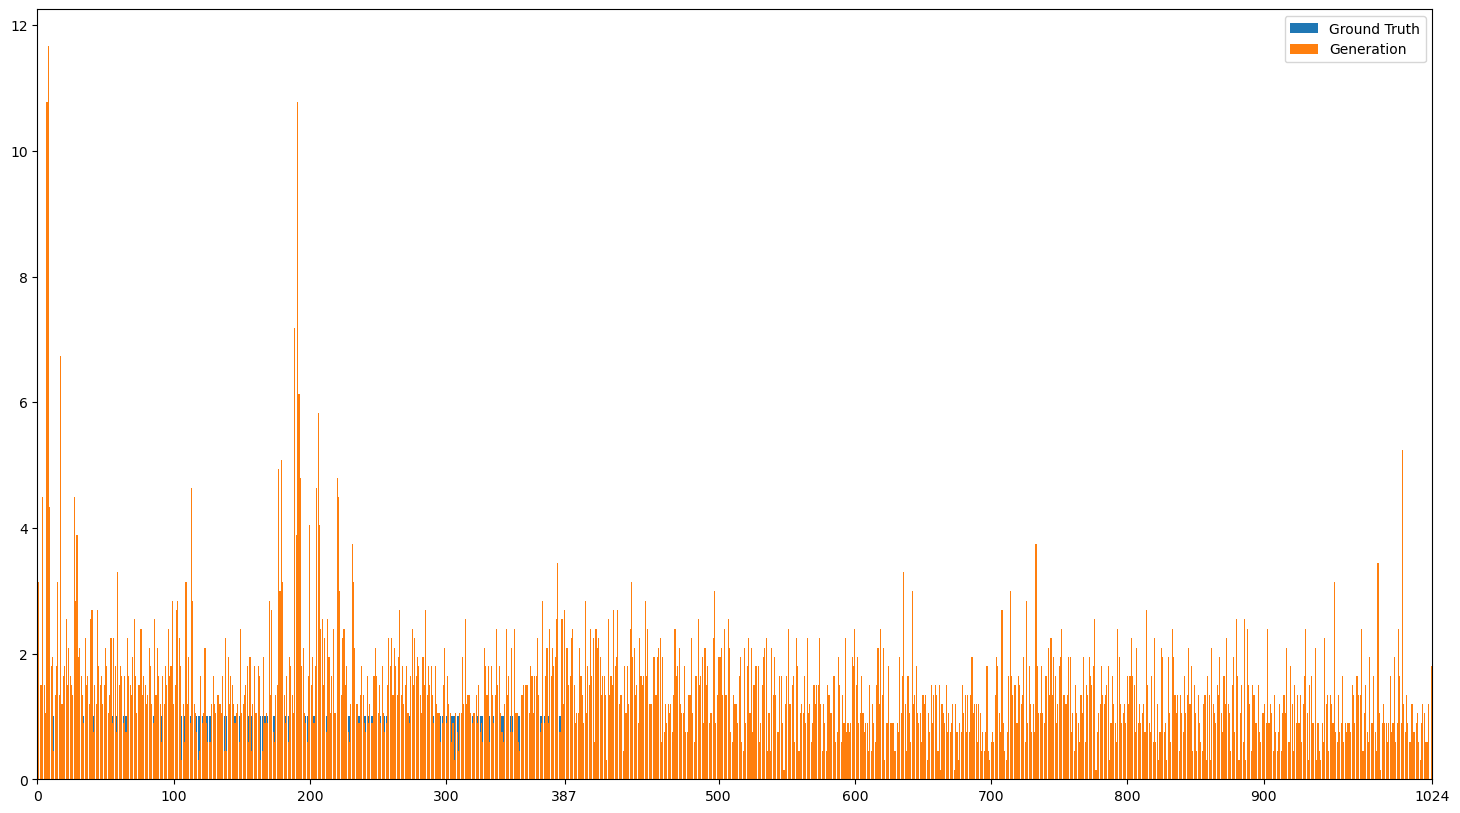

In [174]:
# visualization
x_lim = reordered_set.shape[1]
n_ticks = 8
xtick = np.arange(0,x_lim,int(x_lim/n_ticks/100+0.5)*100)
xtick[np.argmin(np.abs(xtick - values_d.size))] = values_d.size
xtick[-1] = x_lim

fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values_d,counts_d,label = "Ground Truth")
ax.bar(values_t,counts_t,label = "Generation")
ax.set(xlim=(0, x_lim), xticks=xtick)
plt.legend()

In [175]:
statistics

{'percent': 0.4478,
 'FN': array([], dtype=int32),
 'n_fn': 0,
 'FP': array([[ 387,  388,  389, ..., 1020, 1021, 1023],
        [  18,   14,   14, ...,    4,    8,   12]], dtype=int64),
 'n_fp': 636}

In [176]:
MSE

0.41329566

'percent': 0.5181, 0.5236; 0.5698,0.6098,0.6213

n_fn': 4,0,0; 4,3,4

'n_fp': 640,653,641; 615,619,599

MSE: 0.3995,0.3457,0.9405; 0.8118,0.7598,0.7739

In [2]:
int('1101',2)

13